# TCA  (Tranfert componant analysis)

In [1]:
## Ipython magic commands...! 

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
### All the packages we need:
from Traj_creator import Traj_data
from TCA import *
from Mitocheck_Read import MitoCheck_Read
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

# $X_S$

In [3]:
## Well name

if os.path.isfile("H2B_N_F_0.csv"):
    print "The file existed so I loaded it."
    H2B_N_F_0 = Traj_data(file_name="H2B_N_F_0.csv",pkl_traj_file="./Pkl_file") 
    H2B_N_F_0.caract="Normalized by dividing by first element"

else:    
    H2B_N_F_0=Traj_data()#(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2B_N_F_0.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
#    H2B_N_.add_error() ## We had it so that the data won't have to do 0/0

    H2B_N_F_0.Add_traj(normalize=True,all_traj=False,average=False,diff=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2B_N_F_0.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2B_N_F_0.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.

    H2B_N_F_0.data.to_csv('H2B_N_F_0.csv',index=False,header=True)

    

if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.train.columns:
    H2B_N_F_0.missing_features_train()
if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.data.columns:
    H2B_N_F_0.missing_features_data()

        
X_S=H2B_N_F_0.train.ix[pd.notnull(H2B_N_F_0.train['traj']),H2B_N_F_0.names+["Type"]]


X_S.dropna(axis=0)
Y_S=X_S["Type"]
X_S=X_S[H2B_N_F_0.names]

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/naylor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# $X_T$

In [4]:
MitoCheck = MitoCheck_Read()
MitoCheck.Normalize(division=True,average=False)  

if MitoCheck.Var_missing[0] in MitoCheck.data.columns:
    MitoCheck.missing_features()

X_T=MitoCheck.data[MitoCheck.names]

aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  152on well 074
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  0on well 304
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  58on well 304
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  64on well 304
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  79on well 304
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  95on well 304
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No co

MitoCheck_Read()
Because of missing values I adjusted it, in the case X_t/X_0


aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  582on well 063
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  595on well 063
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))


# Getting matrix W

## Rescaling the data

As we are going to be using a kernel trick we have to normalize the data, in particular as we are interested in differences in distributions it is interesting to set the data as it will have 0 mean and variance 1.

In particular: $$X'_S=\frac{X_S-\bar{X_S}}{\sqrt{V(X_S)}}$$ 

And : $$X'_T=\frac{X_T-\bar{X_T}}{\sqrt{V(X_T)}}$$

In [5]:
## We get ride of features where their variance is 0
Std_X_S=np.std(X_S,axis=0)
print "number of features in the data before: %d" %(X_S.shape[1])
new_names_X_S=[el for el in X_S.columns if np.std(X_S[el])!=0]
new_names_X_T=[el for el in X_T.columns if np.std(X_T[el])!=0]
if new_names_X_S==new_names_X_T:
    new_names = new_names_X_T  
else:
    new_names = list(set(new_names_X_S).intersection(new_names_X_T))
X_S=X_S[new_names]
X_T=X_T[new_names]
print "number of features in the data after : %d" %(X_S.shape[1])

# variable granu_open_area_5 is having difficulties as the mean of granu_open_area_5 is inf,
# so infinite values have to be removed, ask Thomas about it
n_orig=X_T.shape[0]

X_T=X_T.replace([np.inf, -np.inf], np.nan)
X_T=X_T.dropna(axis=0, how='any')

mean_X_S=np.mean(X_S,axis=0)
Std_X_S =np.std(X_S,axis=0)

mean_X_T=np.mean(X_T,axis=0)
Std_X_T =np.std(X_T,axis=0)

X_S=X_S.apply(lambda x: (x-mean_X_S)/Std_X_S,axis=1)
X_T=X_T.apply(lambda x: (x-mean_X_T)/Std_X_T,axis=1)

#Taking inf values and missing values

X_T=X_T.dropna(axis=0, how='any')
n_late=X_T.shape[0]
print "number of instances in the data before: %d" %(n_orig)
print "number of instances in the data after : %d" %(n_late)

number of features in the data before: 235
number of features in the data after : 233
number of instances in the data before: 18502
number of instances in the data after : 18502


In [10]:
from random import seed
seed(201)
m    =40  # dimension of the new feature space
mu   =0.1  # weigth scalar to tune (maybe)
gamma=10   # hyper parameter for the gaussian kernel
p    =2    # p norm used to calculate the distances between samples
random_sample_T=0.05  # Fraction of the task domain to use

W_eigenValues,W_eigenVectors,K=TCA(X_S,X_T,m,mu,gamma,p,random_sample_T)

925 samples taken from the task domain


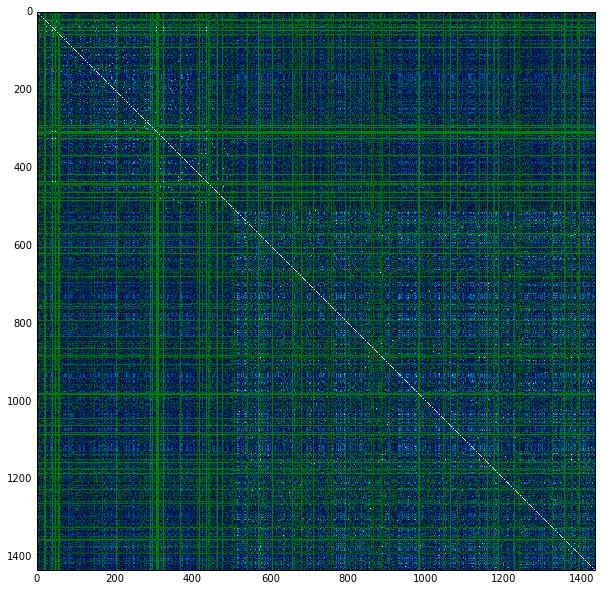

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #plot size

K=np.array(K)
fig = plt.figure()
plt.imshow(K, interpolation='nearest', cmap=plt.cm.ocean)
plt.axis([0, K.shape[0] , K.shape[1], 0])
plt.pcolor(K, cmap=plt.cm.ocean, vmin=0, vmax=1) 
plt.show()      


In [13]:
## Because of the inversion problem we have a null imaginary part, just to be sure it
## doesn't mess anything up in the next part...
W_eigenVectors=sp.real(W_eigenVectors)

training=(sp.mat(W_eigenVectors.T)*sp.mat(K)).T[0:508]
train=pd.DataFrame(training)
train.head()

Processing time: 3.713843 in sec


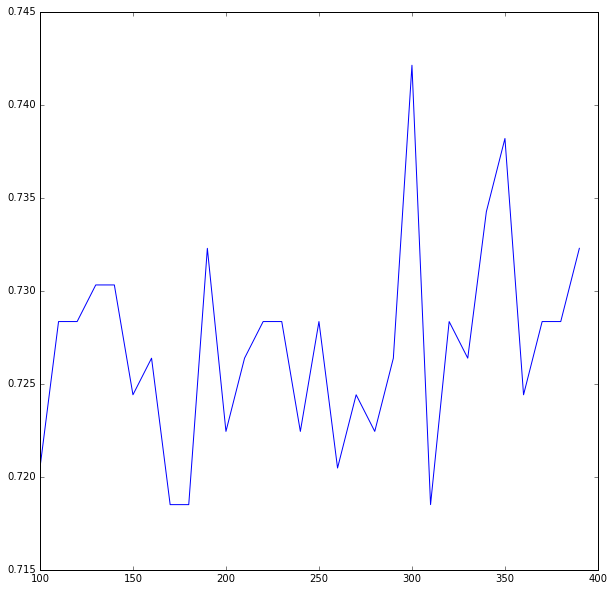

In [14]:
## Results for m=40

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train,Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 2.427693 in sec


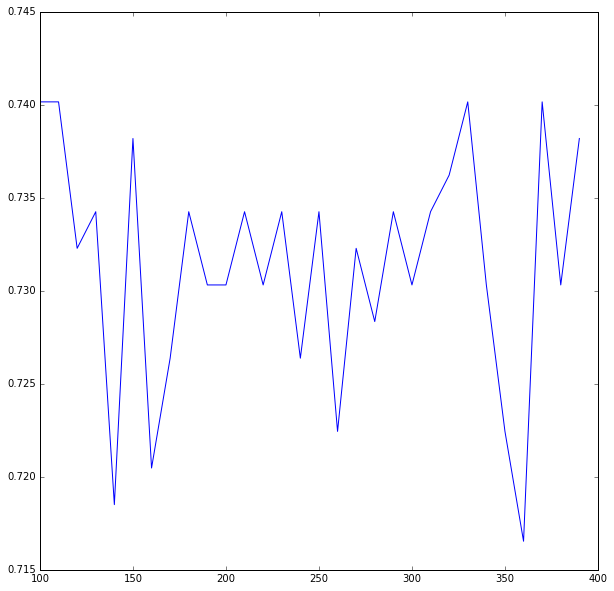

In [19]:
## Results for m=30
m_bis=30

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 3.648226 in sec


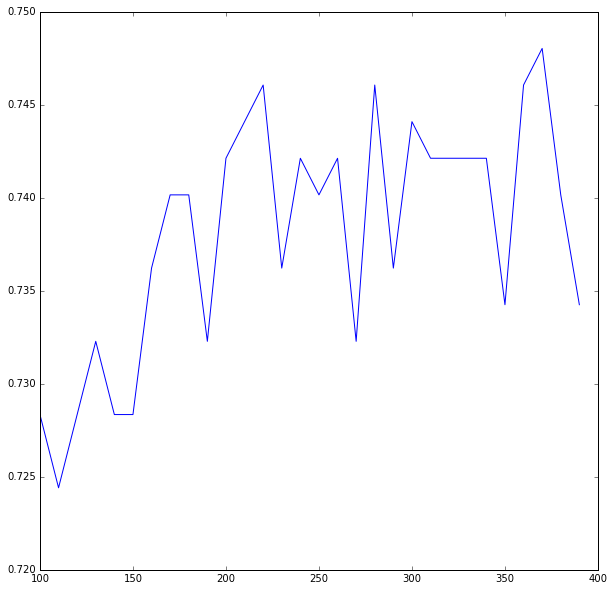

In [20]:
## Results for m=20
m_bis=20

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 2.821912 in sec


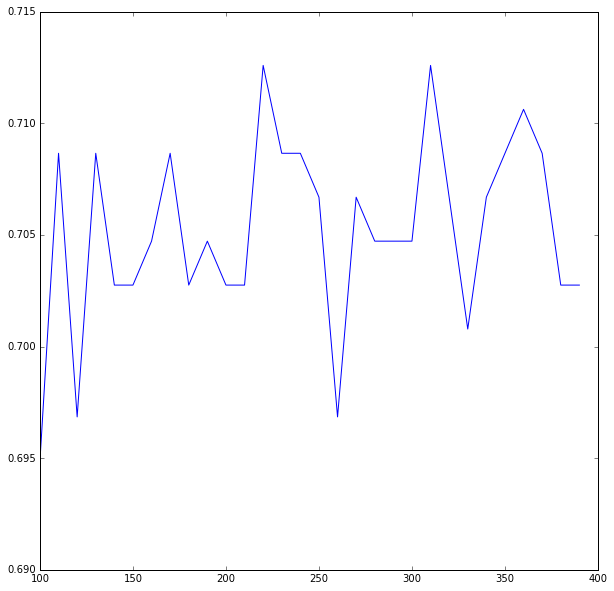

In [21]:
## Results for m=30
m_bis=10

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()